In [93]:
#!pip install pyomo

import numpy as np
import pyomo.environ as pyo
from pathlib import *
from pyomo.opt import SolverFactory
from gurobipy import *

import os
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import time
import math

from datetime import datetime

param = {
"WLSACCESSID": '31c22531-09db-4b06-8466-f0589ec53ca2',
"WLSSECRET": '1db38aec-7d75-4e91-aadb-aed504137cf7',
"LICENSEID": 943442,
}

gurobi_environment = Env(params=param)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 943442
Academic license 943442 - for non-commercial use only - registered to j.___@student.vu.nl


# Main Algorithm

In [94]:
def compute_switch_over(tilde_m, tilde_m_squared):
    unif = 10
    theta = np.zeros((tilde_m_squared, tilde_m_squared), dtype=float)
    for i in range(tilde_m_squared):
        for j in range(tilde_m_squared):
            np.random.seed(i+j)
            if (i < j):
                distance = np.random.uniform(low=0, high=unif, size=1)[0];
                theta[i][j] = distance
                theta[j][i] = distance
    
    return theta

tilde_m = 4
tilde_m_squared = tilde_m**2; # Number of subregion in A

theta = compute_switch_over(tilde_m, tilde_m_squared)

In [95]:
class reward_object:
    def __init__(self, index, value):
        self.index = index
        self.value = value
        
def check_nonempty_queues_path(next_queue_index, I_min, tilde_n_min, cur_queue_index, theta, all_reward_values, mu, arrival_rate_Q):
    # ADD Check if there is a nonempty queue on the path to next_queue_index
    global tilde_m
    reward_queue_index = next_queue_index

    distance_current_reward = theta[cur_queue_index-1][next_queue_index-1]
    
    num_nonempty_queues_path = len(I_min)-1
    rho_Q = arrival_rate_Q*mu
    
    changed_bool = 0
    
    direct_indirect_local_rewards = [0.0]*len(I_min)
    indices_queues_on_path = []
    queue_numbers_on_path = []
    
    for index in range(1,num_nonempty_queues_path+1):
        considered_queue_index = I_min[index]
        if (considered_queue_index == reward_queue_index):
            indices_queues_on_path.append(index)
            queue_numbers_on_path.append(I_min[index])
        else:
            distance_current_considered = theta[cur_queue_index-1][considered_queue_index-1]
            distance_considered_reward = theta[considered_queue_index-1][reward_queue_index-1]
                        
            if (distance_current_considered + distance_considered_reward < 2*distance_current_reward):   
                indices_queues_on_path.append(index)
                queue_numbers_on_path.append(I_min[index])
    
    gamma = len(indices_queues_on_path)-1
    for direct_index_I_min in indices_queues_on_path:
        direct_queue_index = I_min[direct_index_I_min]
        direct_reward_on_path = np.longdouble(tilde_n_min[direct_index_I_min]/theta[cur_queue_index-1][direct_queue_index-1])
        appeared_during_BP_and_travel = ((((tilde_n_min[direct_index_I_min]+(theta[cur_queue_index-1][direct_queue_index-1]*arrival_rate_Q))*mu)/(1-rho_Q))+ theta[cur_queue_index-1][direct_queue_index-1])*arrival_rate_Q

        reward_sum_next_next = 0.0
        for indirect_index_I_min in indices_queues_on_path:
            if (indirect_index_I_min != direct_index_I_min):
                indirect_queue_index = I_min[indirect_index_I_min]
                distance_direct_to_indirect = theta[direct_queue_index-1][indirect_queue_index-1]
                reward_sum_next_next += np.longdouble((tilde_n_min[indirect_index_I_min]+appeared_during_BP_and_travel+(distance_direct_to_indirect*arrival_rate_Q))/distance_direct_to_indirect) 

        if (reward_sum_next_next > 0):
            next_reward_value = direct_reward_on_path + np.longdouble(reward_sum_next_next/gamma)
        else: 
            next_reward_value = direct_reward_on_path
        direct_indirect_local_rewards[direct_index_I_min] = next_reward_value   
        
    min_distance_queue_on_route = distance_current_reward
    max_direct_indirect_reward = 0.0
    for k in indices_queues_on_path:
        considered_queue_index = I_min[k]
        if (considered_queue_index != reward_queue_index):
            distance_current_considered = theta[cur_queue_index-1][considered_queue_index-1]
            distance_considered_reward = theta[considered_queue_index-1][reward_queue_index-1]
            
            considered_direct_indirect_reward = direct_indirect_local_rewards[k]

            if (distance_current_considered < min_distance_queue_on_route):
                next_queue_index = considered_queue_index
                min_distance_queue_on_route = distance_current_considered
                max_direct_indirect_reward = considered_direct_indirect_reward
                changed_bool = 1
                
            elif (distance_current_considered == min_distance_queue_on_route):
                if (considered_direct_indirect_reward > max_direct_indirect_reward):
                    next_queue_index = considered_queue_index
                    min_distance_queue_on_route = distance_current_considered
                    max_direct_indirect_reward = considered_direct_indirect_reward
                    changed_bool = 1
    
    return next_queue_index, changed_bool, queue_numbers_on_path

        
def compute_rewards(I_min, tilde_n_min, theta_min, theta, arrival_rate_Q, mu):
    m = 1
    
    num_nonempty_queues = len(I_min)-1
    cur_queue_index = I_min[0]
            
    max_reward_value = 0.0
    max_reward_queue_index = 0
    gamma = num_nonempty_queues - 1 
    rho_Q = arrival_rate_Q*mu
    
    all_reward_values = [0.0]*(num_nonempty_queues+1)
    
    # Direct rewards 
    for i in range(1,num_nonempty_queues+1):
        next_queue_reward = I_min[i]
        distance_current_to_next = theta[cur_queue_index-1][next_queue_reward-1]

        appeared_during_BP_and_travel = ((((tilde_n_min[i]+(distance_current_to_next*arrival_rate_Q))*mu)/(1-rho_Q))+ distance_current_to_next)*arrival_rate_Q
        
        reward_sum_next_next = 0.0
        for j in range(1,num_nonempty_queues+1):
            next_next_queue = I_min[j]
            distance_next_to_nextnext = theta[next_queue_reward-1][next_next_queue-1]
            if (next_next_queue != next_queue_reward):                
                total_num_demands = tilde_n_min[j] + appeared_during_BP_and_travel + (distance_next_to_nextnext*arrival_rate_Q)
                reward_sum_next_next += (total_num_demands/distance_next_to_nextnext)
        
        next_reward_value = np.longdouble(tilde_n_min[i]/distance_current_to_next) + np.longdouble(reward_sum_next_next/gamma)
        all_reward_values[i] = next_reward_value
        
        if (next_reward_value > max_reward_value):
            max_reward_value = next_reward_value
            max_reward_queue_index = next_queue_reward
    
    next_queue_index = max_reward_queue_index
    
    next_queue_index, changed_bool, queue_numbers_on_path = check_nonempty_queues_path(next_queue_index, I_min, tilde_n_min, cur_queue_index, theta, all_reward_values, mu, arrival_rate_Q)
    
    return next_queue_index, changed_bool, queue_numbers_on_path

In [96]:
class demand_object:
    def __init__(self, index, interarrival_time, service_time, earliest_arrival, queue_index):
        self.index = index
        self.interarrival_time = interarrival_time
        self.service_time = service_time
        self.earliest_arrival = earliest_arrival
        self.queue_index = queue_index
        
def prep_TSP(tilde_n_I, theta, current_queue_index):
    I_min = [current_queue_index]
    tilde_n_min = [0] 
        
    for i in range(len(tilde_n_I)):
        if (tilde_n_I[i] > 0):
            I_min.append(i+1)    
            tilde_n_min.append(tilde_n_I[i])

    theta_min = []
    for x in I_min:
        theta_min_row=[]
        for y in I_min:
            distance_theta = theta[x-1][y-1]
            theta_min_row.append(distance_theta)
        theta_min.append(theta_min_row)

    return I_min, tilde_n_min, theta_min

def wait_for_arrival():
    global lam; global mu; global m; global number_nodes_in_system; global lower_earliest; global sigma
    global all_demands
    np.random.seed(number_nodes_in_system)
    A = np.random.exponential(scale = 1/lam, size=1)[0];
    S = np.random.uniform(0, 1, size = 1)[0]
    queue_index = np.random.randint(1,tilde_m_squared+1)
    demand = demand_object(number_nodes_in_system+1, A, S, lower_earliest + A, queue_index);
    all_demands[number_nodes_in_system] = demand
    return demand;

def add_newly_appeared(available_nodes, maximum_time):
    global number_available_nodes_queue
    global number_nodes_in_system
    global lower_earliest
    global simulation_demands_amount
    
    while (number_nodes_in_system < simulation_demands_amount):
        new_available_node = wait_for_arrival();
        if (new_available_node.earliest_arrival <= maximum_time):
            temp_queue_index = new_available_node.queue_index
            available_nodes[temp_queue_index-1].append(new_available_node);
            number_available_nodes_queue[temp_queue_index-1] += 1;
            number_nodes_in_system += 1;
            lower_earliest = new_available_node.earliest_arrival;
        else:
            break;
            
    return available_nodes;

def determine_NN(number_available_nodes_queue, theta, current_queue_index):
    counter = 1
    distance = float('inf')
    for value in number_available_nodes_queue:
        if (value > 0 and theta[current_queue_index-1][counter-1] < distance):
            NN_index = counter
            distance = theta[current_queue_index-1][NN_index-1]
        counter += 1
    current_queue_index = NN_index
    return current_queue_index

def determine_SLQ(number_available_nodes_queue, theta, current_queue_index):
    max_value = 1
    counter = 1
    distance = float('inf')
    for value in number_available_nodes_queue:
        if (value >= max_value and theta[current_queue_index-1][counter-1] < distance):
            max_value = value
            max_index = counter
            distance = theta[current_queue_index-1][max_index-1]
        counter += 1
    current_queue_index = max_index
    return current_queue_index

def next_predetermined(number_available_nodes_queue, current_queue_index, predetermined_path):
    cur_index_predetermined = 0
    number_of_queues = len(predetermined_path)
    
    for i in range(number_of_queues):
        if (current_queue_index == predetermined_path[i]):
            cur_index_predetermined = i
            break
                
    next_queue_index = current_queue_index
    next_index_predetermined = cur_index_predetermined
    while (number_available_nodes_queue[next_queue_index-1] == 0):
        next_index_predetermined = (next_index_predetermined + 1) % (number_of_queues)
        next_queue_index = predetermined_path[next_index_predetermined]
                    
    return next_queue_index

def determine_predetermined_path(theta):
    model = Model(env = gurobi_environment)
    model.Params.LogToConsole = 0

    # Nodes set
    number_queues = len(theta[0])-1
    queues = range(number_queues+1) # produce list from 0 through tilde n 
    queues_excl = range(1,number_queues+1)
    
    tour = model.addMVar((number_queues+1, number_queues+1), vtype=GRB.BINARY, name="tour")
    u = model.addMVar(number_queues, vtype= GRB.CONTINUOUS, lb = 0, ub = GRB.INFINITY)
    
    model.setObjective(sum(tour[i, j] * theta[i,j] for i in queues for j in queues if i != j), GRB.MINIMIZE)
    
    model.addConstrs(sum(tour[i, j] for j in queues if i != j) == 1 for i in queues_excl)
    model.addConstrs(sum(tour[i, j] for i in queues if i != j) == 1 for j in queues_excl)
    model.addConstr(sum(tour[i, 0] for i in queues_excl) == 1)

    # Eliminate subtours using Miller-Tucker-Zemlin (MTZ) Constraints 
    model.addConstrs(u[i-1] - u[j-1] + (number_queues*tour[i,j]) <= number_queues - 1 for i in queues_excl for j in queues_excl if i != j)

    model.optimize();
    result = tour.X
    
    current_queue = 0
    predetermined_path = [1]*(number_queues+1)
    for l in range(1,number_queues+1):
        adjacency_row = result[current_queue]
        next_queue = np.where(adjacency_row == max(adjacency_row))[0][0]
        predetermined_path[l] = next_queue+1
        current_queue = next_queue
    
    return predetermined_path
    

def simulate_non_uniform_algorithm(theta, policy_type):
    global simulation_demands_amount; global m; global tilde_m; global tilde_m_squared;
    global number_available_nodes_queue; global number_nodes_in_system; global lower_earliest;
    global lam; global mu
    
    number_visited_nodes = 0;
    
    available_nodes = []; 
    for i in range(tilde_m_squared):
        available_nodes.append([])
        
    current_time = 0.0;
    lower_earliest = 0.0;
        
    result_waiting_times_array = [0]*simulation_demands_amount
    
    arrival_rate_Q = lam/tilde_m_squared

    start_time_time = time.time()
    
    predetermined_path = determine_predetermined_path(theta)
    
    current_queue_index = 1
    
    total_check_NN_TSP = 0
    equality_check_NN_TSP = 0
    contained_check_NN_TSP = 0
    
    while (number_visited_nodes < simulation_demands_amount):
        
        """STATUS PRINTING"""
        if ((time.time()-start_time_time)/60 >= 0.5):
            now = datetime.now()
            now_time = now.strftime("%H:%M:%S")
            print(f"{now_time}: NUMBER DEMANDS VISITED: {number_visited_nodes}/{simulation_demands_amount}")
            start_time_time = time.time()
        """STATUS PRINTING"""
        
        #"""Initialization"""        
        available_nodes = add_newly_appeared(available_nodes, current_time);
           
        time_waited = 0.0;
        switch_over_time = 0.0
        prev_queue_index = current_queue_index
        
        if (sum(number_available_nodes_queue) == 0): 
            next_node = wait_for_arrival(); 
            current_queue_index = next_node.queue_index # Update current queue
            lower_earliest = next_node.earliest_arrival;
            number_nodes_in_system += 1;
            time_waited = next_node.earliest_arrival - current_time
            switch_over_time = theta[prev_queue_index-1][current_queue_index-1]
            
        elif (number_available_nodes_queue[current_queue_index-1] > 0): 
            next_node = available_nodes[current_queue_index-1][0]
            available_nodes[current_queue_index-1].remove(next_node);
            number_available_nodes_queue[current_queue_index-1] -= 1;

        elif (np.count_nonzero(number_available_nodes_queue) == 1): 
            # If there is one other queue with available nodes, go to that queue.
            for l in range(tilde_m_squared):
                if (number_available_nodes_queue[l] > 0):
                    current_queue_index = l+1
                    break

            next_node = available_nodes[current_queue_index-1][0]
            available_nodes[current_queue_index-1].remove(next_node);
            number_available_nodes_queue[current_queue_index-1] -= 1;
            switch_over_time = theta[prev_queue_index-1][current_queue_index-1]

        else: 
            if (policy_type == "rewards"):
                I_min, tilde_n_min, theta_min = prep_TSP(number_available_nodes_queue, theta, current_queue_index)                       
                prev_current_queue_index = current_queue_index
                current_queue_index, changed_bool, queue_numbers_on_path = compute_rewards(I_min, tilde_n_min, theta_min, theta, arrival_rate_Q, mu)
                
            elif (policy_type == "SLQ"):
                current_queue_index = determine_SLQ(number_available_nodes_queue, theta, current_queue_index)
            elif (policy_type == "predetermined"):
                current_queue_index = next_predetermined(number_available_nodes_queue, current_queue_index, predetermined_path)
            elif (policy_type == "NNP"):
                current_queue_index = determine_NN(number_available_nodes_queue, theta, current_queue_index)
            else:
                raise ValueError(f"Sorry, type {policy_type} not known")
            
            switch_over_time = theta[prev_queue_index-1][current_queue_index-1]
            next_node = available_nodes[current_queue_index-1][0]
            available_nodes[current_queue_index-1].remove(next_node);
            number_available_nodes_queue[current_queue_index-1] -= 1;
                        
        result_waiting_times_array[number_visited_nodes] = current_time + time_waited + switch_over_time - next_node.earliest_arrival
        current_time += time_waited + switch_over_time + next_node.service_time;
        current_node = next_node;
        number_visited_nodes += 1;
        if (result_waiting_times_array[number_visited_nodes-1] < 0):
            raise ValueError(f"ERROR")
            
    return result_waiting_times_array

In [97]:
# parameters
system_loads = 0.5
simulation_demands_amount = 1000000 # Maximum number of demands per simulation
m = 1 # Square region A has size m x m
#mu = 1/10;
mu = 1/2
lam = system_loads/mu; # Arrival rate of individual dynamic demands
sigma = 0;

number_available_nodes_queue = [0]*tilde_m_squared;
number_nodes_in_system = 0;
lower_earliest = 0.0;
all_demands = [None]*simulation_demands_amount

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print(f"Starting time = {current_time}")


start_time = time.time() # START TIME
#policy_type = "predetermined" # Choose from "rewards", "SLQ", "predetermined" or "NNP"
#policy_type = "SLQ"
#policy_type = "rewards"
policy_type = "NNP"
result_waiting_times_array = simulate_non_uniform_algorithm(theta, policy_type);

print(f"I have finished in {(time.time() - start_time)/60} minutes")

Starting time = 20:49:45
20:50:15: NUMBER DEMANDS VISITED: 723027/1000000
I have finished in 0.7066826184590658 minutes


## Results - Waiting Times - Batch Means

In [98]:
if (simulation_demands_amount == 1000000):
    warm_up_period_min = 500000
    warm_up_period_max = 800000
    sample_size = 7500
else:
    raise ValueError(f"Invalid simulation amount")

number_of_samples = int((warm_up_period_max-warm_up_period_min)/sample_size)
print(f"number of samples = {number_of_samples}")

batch_sample = []

for j in range(number_of_samples):
    mean_sample = np.mean(result_waiting_times_array[warm_up_period_min+(j*sample_size):warm_up_period_min+((j+1)*sample_size)])
    batch_sample.append(mean_sample)
    
CI_batches = [np.mean(batch_sample) - (1.96*statistics.stdev(batch_sample)/np.sqrt(number_of_samples)),np.mean(batch_sample) + (1.96*statistics.stdev(batch_sample)/np.sqrt(number_of_samples))]
sigma_batches = (statistics.stdev(batch_sample))

sigma_wait = (statistics.stdev(result_waiting_times_array[warm_up_period_min:warm_up_period_max]))


print(f"Waiting time mean = {np.mean(batch_sample):.4f}")
print(f"Sigma waiting time = {sigma_wait:.4f}")
print(f"CI Batches = [{CI_batches[0]:.4f},{CI_batches[1]:.4f}]")

number of samples = 40
Waiting time mean = 13.7191
Sigma waiting time = 14.6834
CI Batches = [13.6318,13.8063]


# Plotting

In [99]:
convergence = []
convergence_sum = 0;

for k in range(simulation_demands_amount):
    convergence_sum += result_waiting_times_array[k]
    convergence.append(convergence_sum/(k+1))

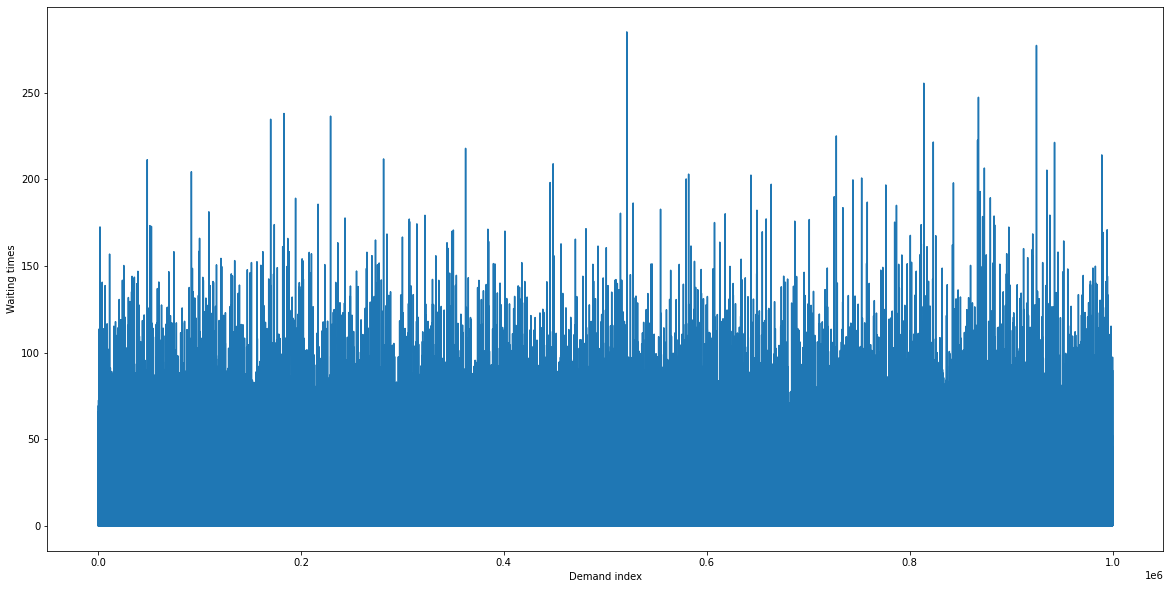

In [100]:
plt.figure(figsize=(20, 10))

plt.plot(range(simulation_demands_amount), result_waiting_times_array)

plt.title('')
plt.xlabel('Demand index')
plt.ylabel('Waiting times')
plt.show()

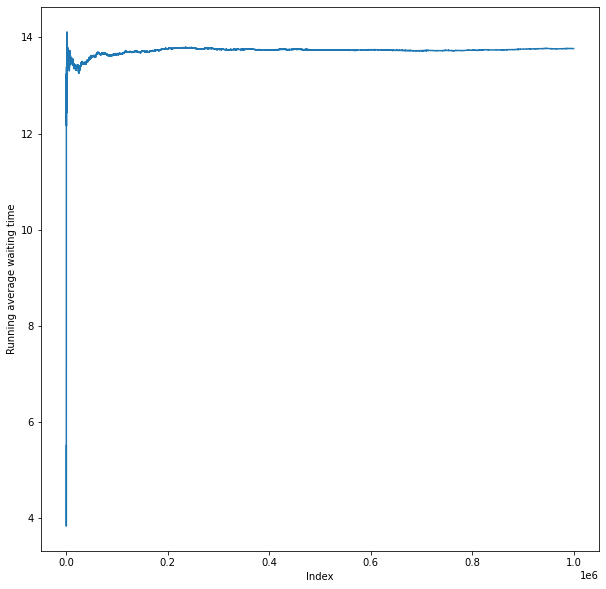

In [101]:
plt.figure(figsize=(10, 10))

plt.plot(range(simulation_demands_amount), convergence)

plt.title('')
plt.xlabel('Index')
plt.ylabel('Running average waiting time')
plt.show()